## Imports

In [1]:
import os
import multiprocessing
import rasterio
import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import keras
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

### Test with Simple CNN and Data Loader 

In [2]:
import boto3
import rasterio as rio
import numpy as np
import io

In [3]:
from data_loader import DataLoader

In [4]:
batch_size = 20
gen = DataLoader(label_file_path_train="labels_test_v1.csv",
                label_file_path_val="val_labels.csv",
                bucket_name='canopy-production-ml',
                data_extension_type='.tif',
                training_data_shape=(100, 100, 18),
                augment=True,
                random_flip_up_down=False, #Randomly flips an image vertically (upside down). With a 1 in 2 chance, outputs the contents of `image` flipped along the first dimension, which is `height`.
                random_flip_left_right=False,
                flip_left_right=False,
                flip_up_down=False,
                rot90=True,
                transpose=False,
                enable_shuffle=False,
                training_data_shuffle_buffer_size=10,
                training_data_batch_size=batch_size,
                training_data_type=tf.float32,
                label_data_type=tf.uint8,
                num_parallel_calls=int(2))


Data augmentation enabled 
Training on 200 images 
Validation on 366 images 


(20, 100, 100, 18)


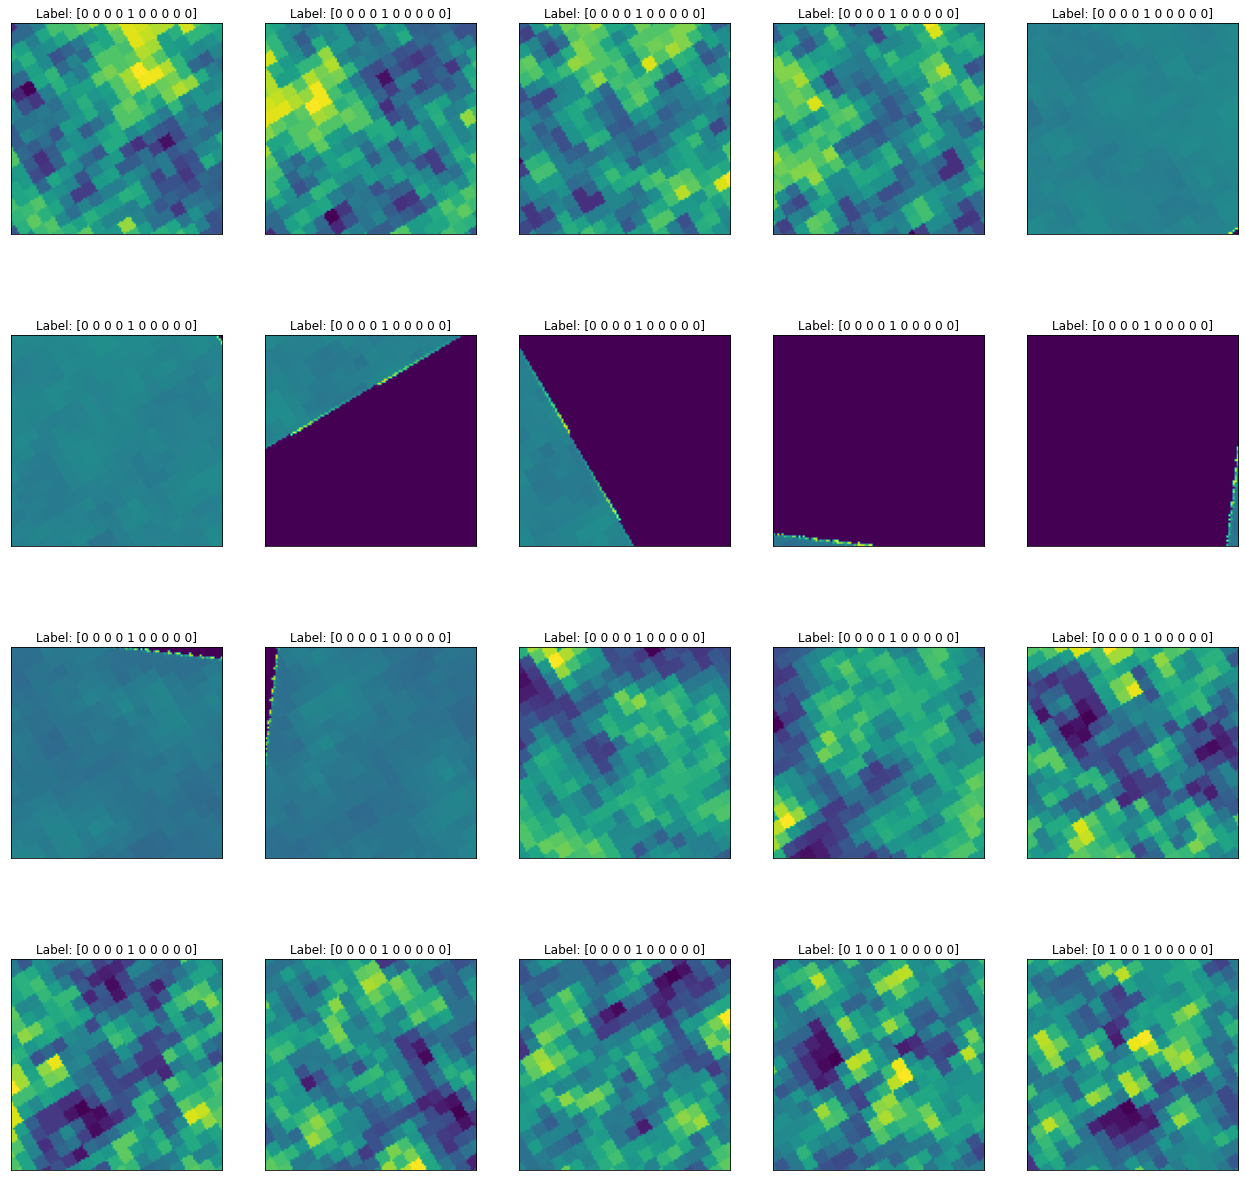

In [5]:
for image, label in iter(gen.training_dataset): # extract 1 batch at a time from the dataset
    image = image.numpy()
    label = label.numpy()
    print(image.shape)    

    fig = plt.figure(figsize=(22, 22))
    for i in range(20): # display 20 first tiles from batch
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i][:,:,0])
        ax.set_title(f"Label: {label[i]}")
    plt.show()
    
    break

(20, 100, 100, 18)


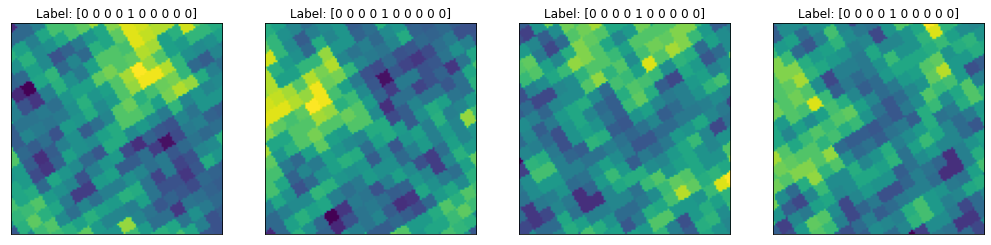

(20, 100, 100, 18)


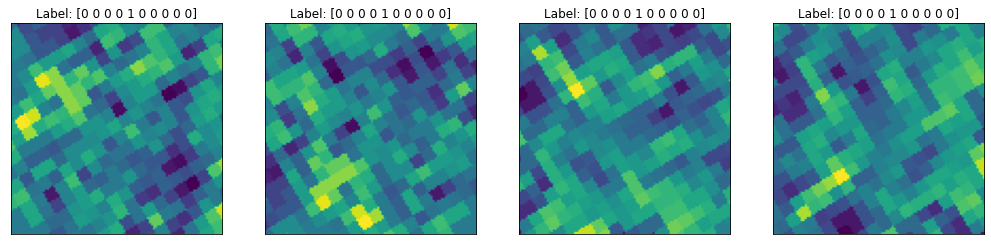

(20, 100, 100, 18)


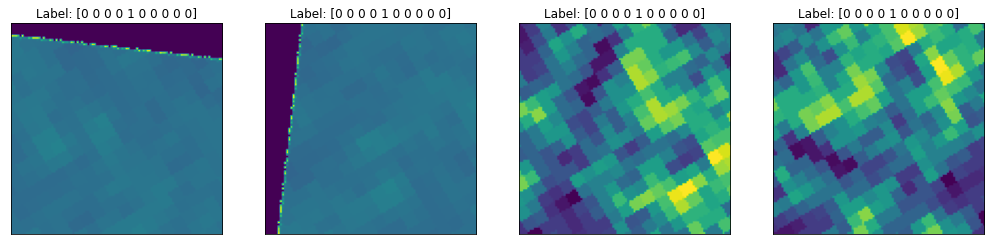

(20, 100, 100, 18)


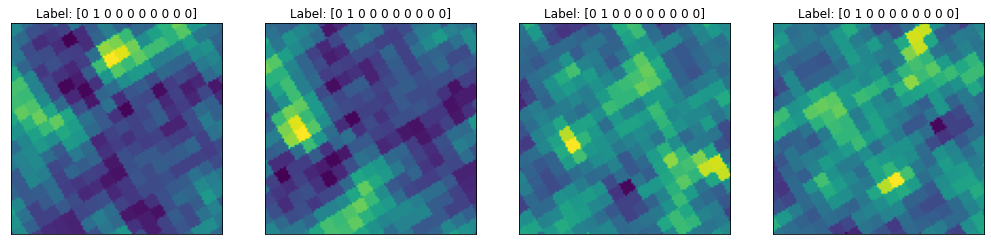

(20, 100, 100, 18)


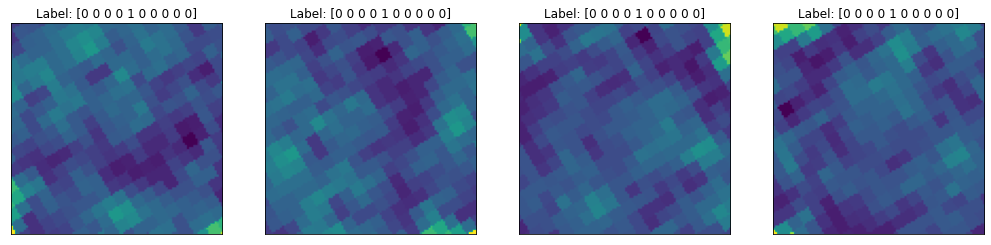

(20, 100, 100, 18)


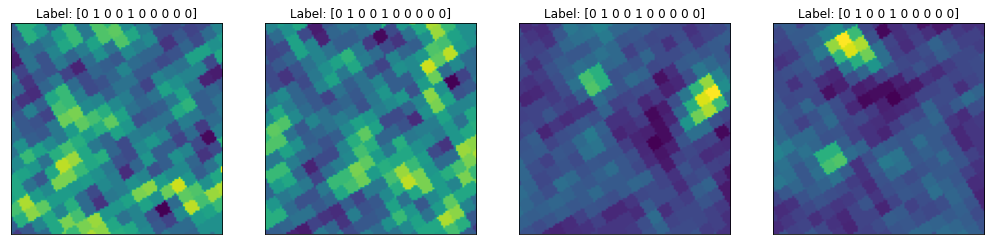

(20, 100, 100, 18)


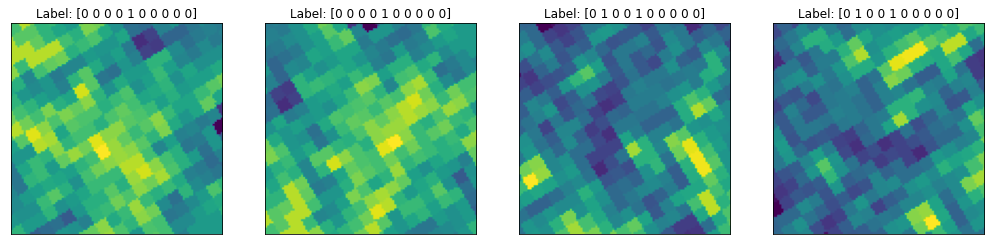

(20, 100, 100, 18)


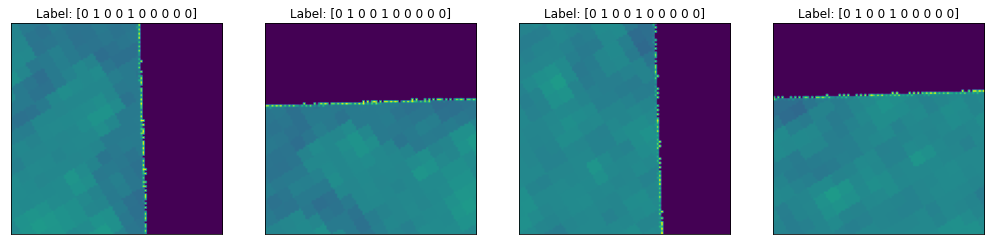

(20, 100, 100, 18)


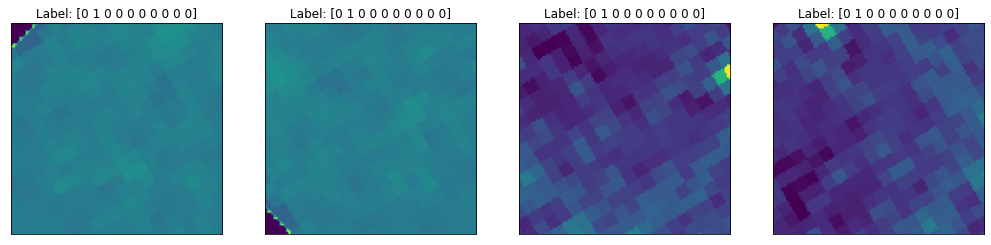

(20, 100, 100, 18)


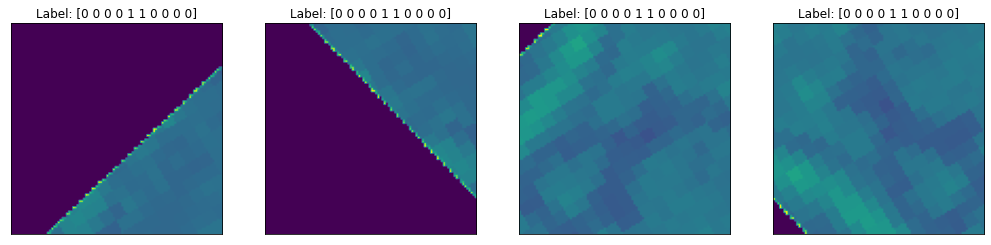

In [6]:
for image, label in iter(gen.training_dataset): # extract 1 batch at a time from the dataset
    image = image.numpy()
    label = label.numpy()
    print(image.shape)    

    fig = plt.figure(figsize=(22, 22))
    for i in range(4): # display 4 first tiles from batch
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i][:,:,0])
        ax.set_title(f"Label: {label[i]}")
    plt.show()



In [7]:
batch_size = 20
gen = DataLoader(label_file_path_train="labels_test_v1.csv",
                label_file_path_val="val_labels.csv",
                bucket_name='canopy-production-ml',
                data_extension_type='.tif',
                training_data_shape=(100, 100, 18),
                augment=True,
                random_flip_up_down=False, #Randomly flips an image vertically (upside down). With a 1 in 2 chance, outputs the contents of `image` flipped along the first dimension, which is `height`.
                random_flip_left_right=False, #same 
                flip_left_right=True,
                flip_up_down=True,
                rot90=False,
                transpose=False,
                enable_shuffle=False,
                training_data_shuffle_buffer_size=10,
                training_data_batch_size=batch_size,
                training_data_type=tf.float32,
                label_data_type=tf.uint8,
                num_parallel_calls=int(2))


Data augmentation enabled 
Training on 200 images 
Validation on 366 images 


(20, 100, 100, 18)


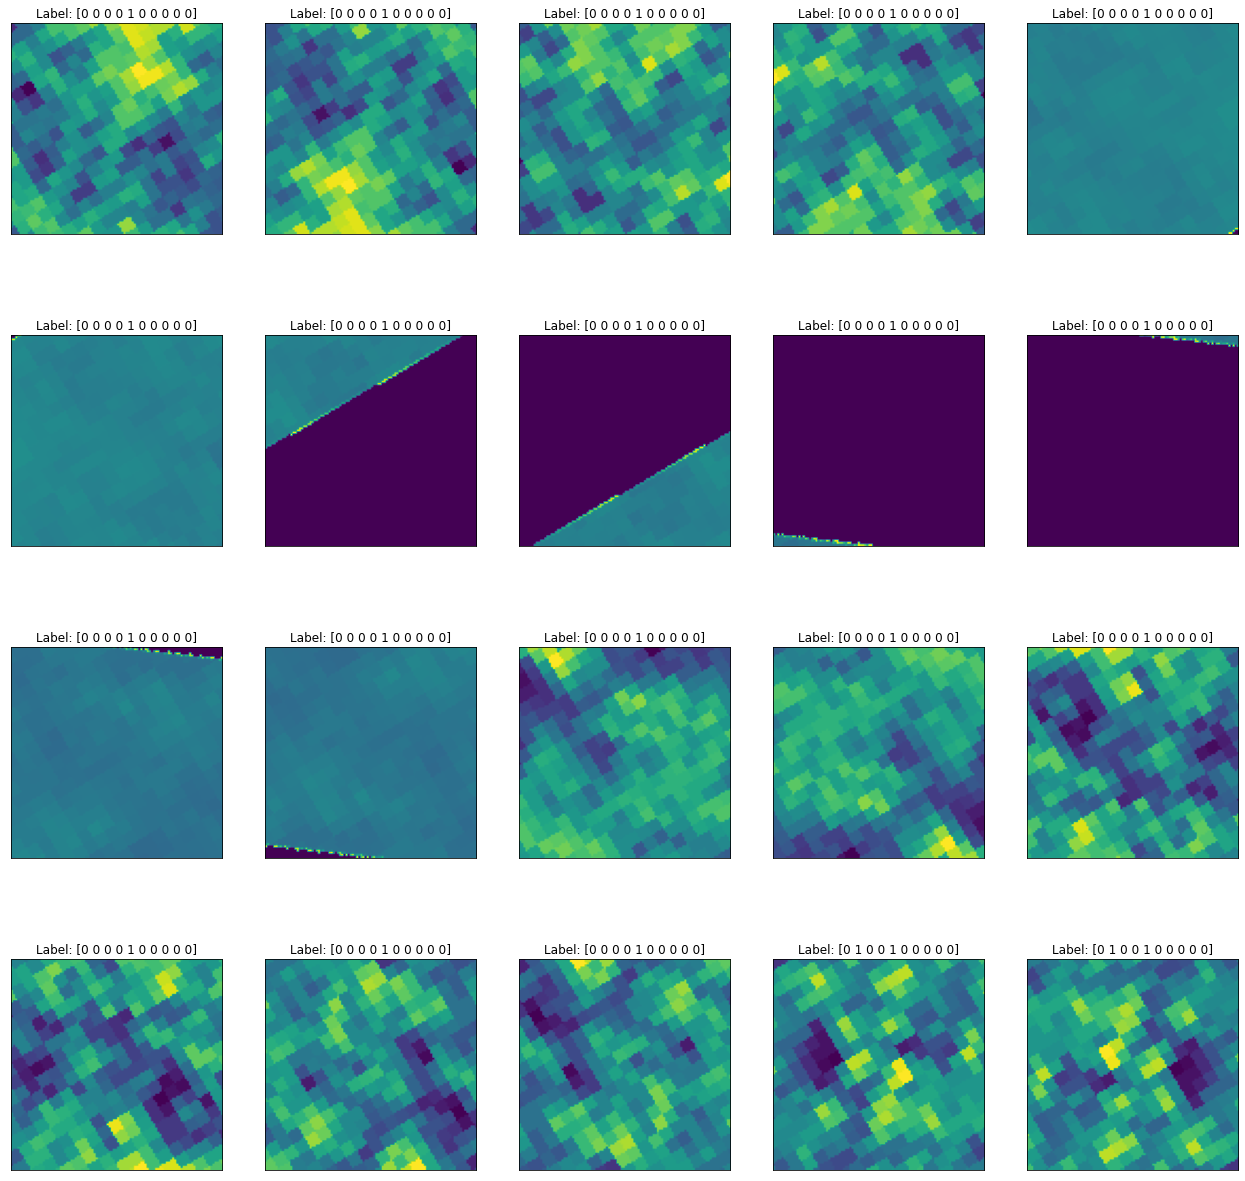

In [8]:
for image, label in iter(gen.training_dataset): # extract 1 batch at a time from the dataset
    image = image.numpy()
    label = label.numpy()
    print(image.shape)    

    fig = plt.figure(figsize=(22, 22))
    for i in range(20): # display 20 first tiles from batch
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i][:,:,0])
        ax.set_title(f"Label: {label[i]}")
    plt.show()
    
    break

In [19]:
def plot_learningCurve(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
#   plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
#   plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Val'], loc='upper left')
  plt.show()

  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Val'], loc='upper left')
  plt.show()




## PREPRODUCTION Candidate: ResNet50 pretrained on ImageNet

Build model

In [10]:
def define_model(numclasses,input_shape):
    # parameters for CNN
    input_tensor = Input(shape=input_shape)

    # introduce a additional layer to get from bands to 3 input channels
    input_tensor = Conv2D(3, (1, 1))(input_tensor)

    base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                              weights='imagenet',
                              input_shape=(100, 100, 3))
    base_model = keras.applications.ResNet50(include_top=False,
                     weights=None,
                     input_tensor=input_tensor)

    for i, layer in enumerate(base_model_resnet50.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())

    # add a global spatial average pooling layer
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)

    # let's add a fully-connected layer
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    # and a logistic layer
    predictions = Dense(numclasses, activation='softmax')(top_model)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

#     model.summary()
    return model

In [11]:
random_id = random.randint(1,101) 
checkpoint_file = 'checkpoint_{}.h5'.format(random_id)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath= checkpoint_file,
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)

model_checkpoint_callback_accuracy = tf.keras.callbacks.ModelCheckpoint(
  filepath= 'checkpoint_accuracy_{}.h5'.format(random_id),
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss', factor=0.1, patience=2, verbose=1,
  mode='min', min_lr=1e-10)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

callbacks_list = [model_checkpoint_callback, reducelronplateau, early_stop]

model = define_model(10, (100,100,18))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                          optimizer=keras.optimizers.Adam(),
                          metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 


Start training

In [12]:
epochs = 10
    
history = model.fit(gen.training_dataset, validation_data=gen.validation_dataset, 
                    epochs=epochs, 
                    callbacks=callbacks_list)


Epoch 1/10
10/10 [==============================] - 287s 31s/step - loss: 0.9624 - accuracy: 0.9136 - val_loss: 2.5619 - val_accuracy: 0.8331

Epoch 00001: val_loss improved from inf to 2.56193, saving model to checkpoint_37.h5
Epoch 2/10
10/10 [==============================] - 297s 32s/step - loss: 0.9042 - accuracy: 0.9412 - val_loss: 2.5619 - val_accuracy: 0.8331

Epoch 00002: val_loss did not improve from 2.56193
Epoch 3/10
10/10 [==============================] - 271s 29s/step - loss: 0.9042 - accuracy: 0.9412 - val_loss: 2.5619 - val_accuracy: 0.8331

Epoch 00003: val_loss did not improve from 2.56193

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
10/10 [==============================] - 266s 29s/step - loss: 0.9042 - accuracy: 0.9412 - val_loss: 2.5619 - val_accuracy: 0.8331

Epoch 00004: val_loss did not improve from 2.56193
Epoch 5/10
10/10 [==============================] - 274s 30s/step - loss: 0.9042 - accuracy: 0.9412 - val_lo

Evaluation

In [13]:
model.evaluate(gen.validation_dataset) 

19/19 [==============================] - 209s 11s/step - loss: 2.5619 - accuracy: 0.8331


[2.5619330406188965, 0.8330602049827576]

In [14]:
s3 = boto3.resource('s3')
# TODO test on entire test dataset
obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(), (1, 2, 0))
print(img_test.shape)
label_list = ['Habitation', 'ISL', 'Industrial_agriculture', 'Mining',
    'Rainforest', 'River', 'Roads', 'Savannah', 'Shifting_cultivation',
    'Water'
]
# TODO Need to do data augmentation

(100, 100, 18)


In [15]:
predictions = model.predict(np.array([img_test]))
highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

print("This chip was predicted to belong to top 3 classes:")

top3 = np.argsort(predictions[0])[:-4:-1]
for i in range(3):
  print(label_list[top3[i]])

This chip was predicted to belong to top 3 classes:
Rainforest
Water
Shifting_cultivation


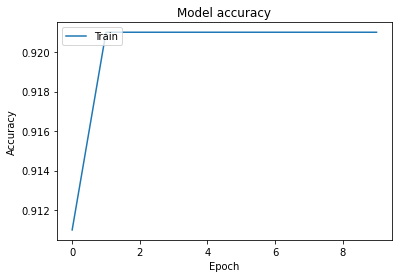

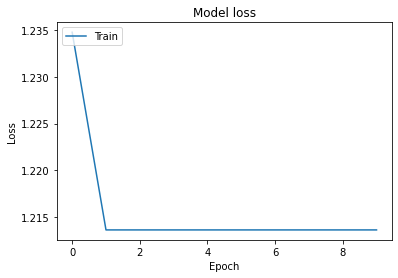

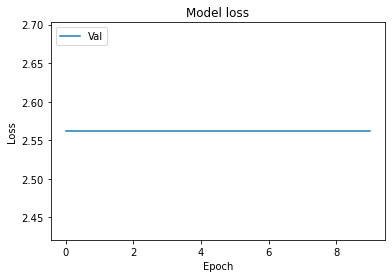

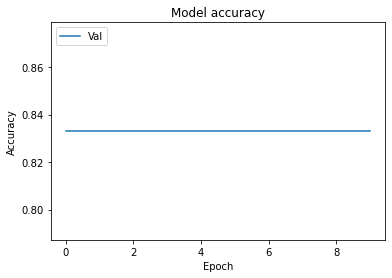

In [20]:
plot_learningCurve(history)